### Spooky Author Identification
The competition dataset contains text from works of fiction written by spooky authors of the public domain: Edgar Allan Poe, HP Lovecraft and Mary Shelley. 
The data was prepared by chunking larger texts into sentences using CoreNLP's MaxEnt sentence tokenizer, so you may notice the odd non-sentence here and there. 
The objective is to accurately identify the author of the sentences in the test set.

Similar to the project done last week on the BBC Kaggle dataset, I wanted to look at applying Non-Negative Matrix Factorization(NMF) and K-Means

NMF Source: https://www.geeksforgeeks.org/non-negative-matrix-factorization/


In [1]:
import numpy as np
import pandas as pd
import re
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF
from matplotlib import pyplot as plt
%matplotlib inline


### EDA
In this section we will inspect, visualize and clean the data

In [2]:
#Look at the datasets and view some basic information about them.
train    = pd.read_csv("train.csv")
test     = pd.read_csv("test.csv")


In [3]:
print(train.head(5))
print(train.info())
print(train.shape)


        id                                               text author
0  id26305  This process, however, afforded me no means of...    EAP
1  id17569  It never once occurred to me that the fumbling...    HPL
2  id11008  In his left hand was a gold snuff box, from wh...    EAP
3  id27763  How lovely is spring As we looked from Windsor...    MWS
4  id12958  Finding nothing else, not even gold, the Super...    HPL
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19579 entries, 0 to 19578
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      19579 non-null  object
 1   text    19579 non-null  object
 2   author  19579 non-null  object
dtypes: object(3)
memory usage: 459.0+ KB
None
(19579, 3)


In [4]:
print(test.head(5))
print(test.info())
print(test.shape)


        id                                               text
0  id02310  Still, as I urged our leaving Ireland with suc...
1  id24541  If a fire wanted fanning, it could readily be ...
2  id00134  And when they had broken down the frail door t...
3  id27757  While I was thinking how I should possibly man...
4  id04081  I am not sure to what limit his knowledge may ...
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8392 entries, 0 to 8391
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      8392 non-null   object
 1   text    8392 non-null   object
dtypes: object(2)
memory usage: 131.3+ KB
None
(8392, 2)


In [5]:
#Then we want to check for any missing values
train.isnull().sum()


id        0
text      0
author    0
dtype: int64

In [6]:
test.isnull().sum()


id      0
text    0
dtype: int64

Since there are no missing values, lets visualize some basic statistics in the data, like the distribution of entries for each author. 

Text(0.5, 1.0, 'Author Count')

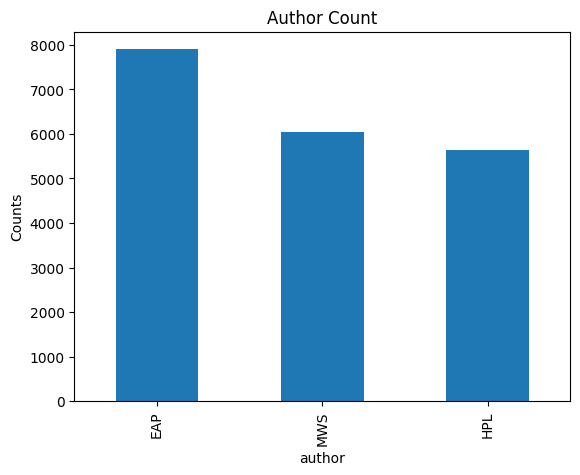

In [7]:
train_count_categoty = train['author'].value_counts()
graph = train_count_categoty.plot.bar()
plt.ylabel('Counts')
graph.set_title('Author Count')


Looking at the plot above, we can see that the number of excerpts for EAP are greater than MWS and HPL.

Text(0.5, 1.0, 'Word Frequency Used')

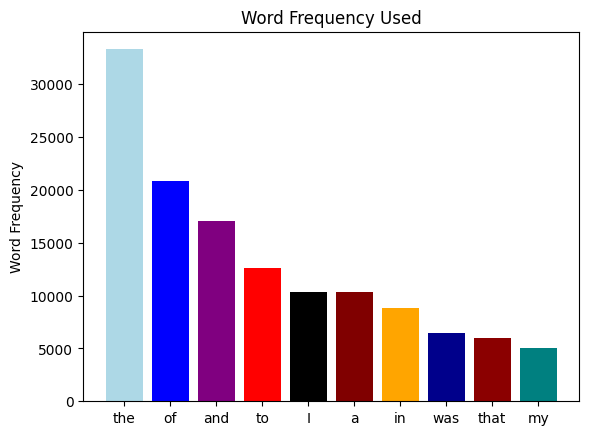

In [8]:
all_words = train['text'].str.split(expand=True).unstack().value_counts()
x = all_words.index.values[0:10]
y = all_words.values[0:10]
color = ['lightblue', 'blue', 'purple', 'red', 'black', 'maroon', 'orange', 'darkblue', 'darkred', 'teal']
graph = plt.bar(x,y, color=color)
plt.ylabel('Word Frequency')
plt.title('Word Frequency Used')


In the plot above, notice that the frequecy of words is the highest with common words. This plot looks at the top 10 words. Lets take a look then at the bottom 10 words.

Text(0.5, 1.0, 'Word Frequency Used')

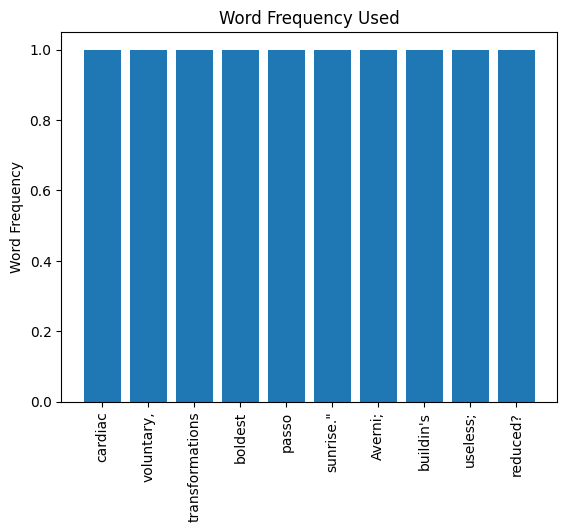

In [9]:
x = all_words.index.values[-10:]
y = all_words.values[-10:]
graph = plt.bar(x,y)
plt.xticks(rotation=90)
plt.ylabel('Word Frequency')
plt.title('Word Frequency Used')


Looking at this plot, we notice that some of the words in our array have special characters("',; etc.). We will need to handle this before we look at building our models.

So thinking further, lets ask ourselves if there are any types of words that each author uses more frequently? To visualize this, we can leverage wordclouds. First we want to process our data and remove characters, numbers, etc.

In [10]:
#clean text
train['text_processed'] = train['text'].map(lambda x: re.sub('[,\.!?]','',x))
train['text_processed'] = train['text_processed'].map(lambda x:x.lower())
print(train['text_processed'].head())

# remove all characters, number or characters
def cleanText(input_string):
    modified_string = re.sub('[^A-Za-z0-9]+', ' ', input_string)
    return(modified_string)

train['text_processed'] = train.text_processed.apply(cleanText)


0    this process however afforded me no means of a...
1    it never once occurred to me that the fumbling...
2    in his left hand was a gold snuff box from whi...
3    how lovely is spring as we looked from windsor...
4    finding nothing else not even gold the superin...
Name: text_processed, dtype: object


In [ ]:
#Create array for each authors texts
eap = train[train.author=="EAP"]["text"].values
hpl = train[train.author=="HPL"]["text"].values
mws = train[train.author=="MWS"]["text"].values


(-0.5, 399.5, 199.5, -0.5)

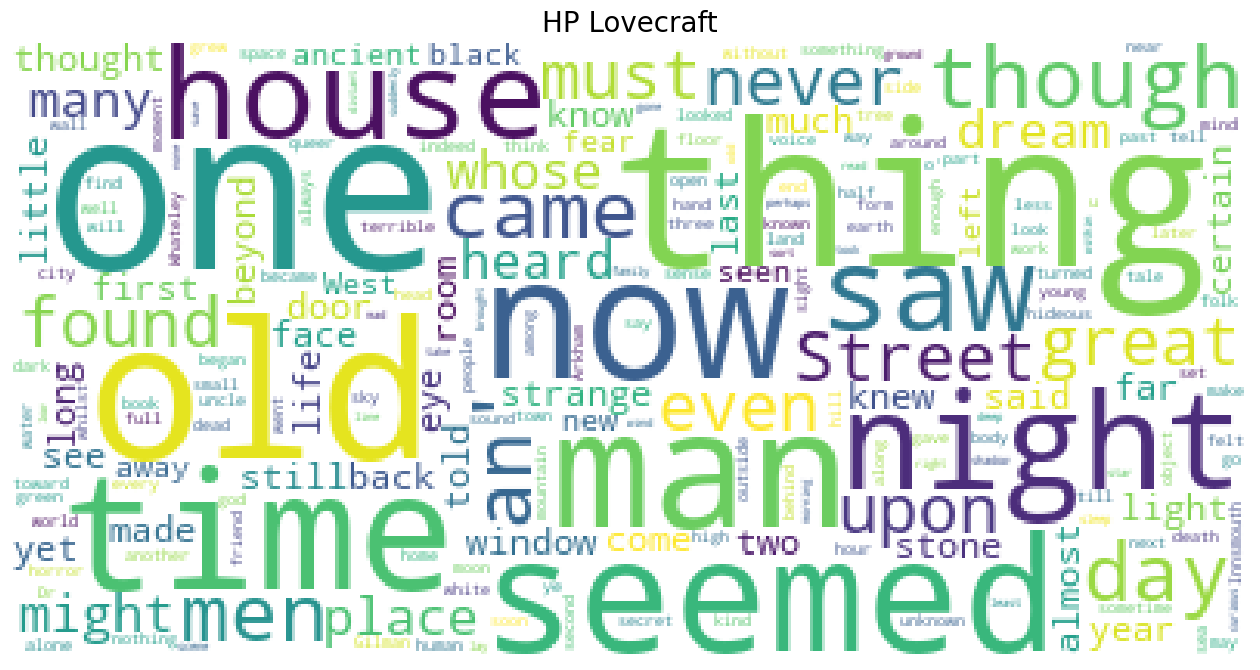

In [23]:
from wordcloud import WordCloud, STOPWORDS

plt.figure(figsize=(16,13))

wordcloud = WordCloud(background_color="white",
                      max_words= 500,
                      contour_width = 8,
                      contour_color = "steelblue",
                     collocations=False).generate(" ".join(hpl))

plt.title("HP Lovecraft", fontsize=20)
plt.imshow(wordcloud.recolor( colormap= 'viridis' , random_state=17), alpha=0.98)
plt.axis('off')


(-0.5, 399.5, 199.5, -0.5)

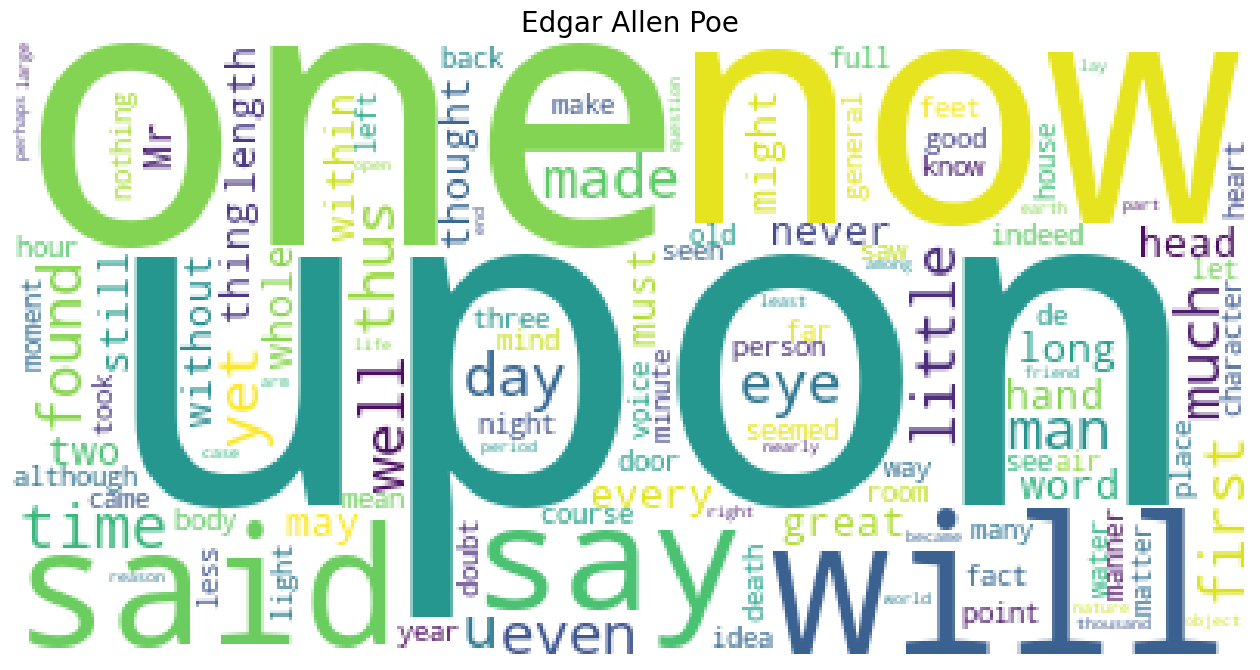

In [24]:
plt.figure(figsize=(16,13))

wordcloud = WordCloud(background_color="white",
                      max_words= 500,
                      contour_width = 8,
                      contour_color = "steelblue",
                     collocations=False).generate(" ".join(eap))

plt.title("Edgar Allen Poe", fontsize=20)
plt.imshow(wordcloud.recolor( colormap= 'viridis' , random_state=17), alpha=0.98)
plt.axis('off')


(-0.5, 399.5, 199.5, -0.5)

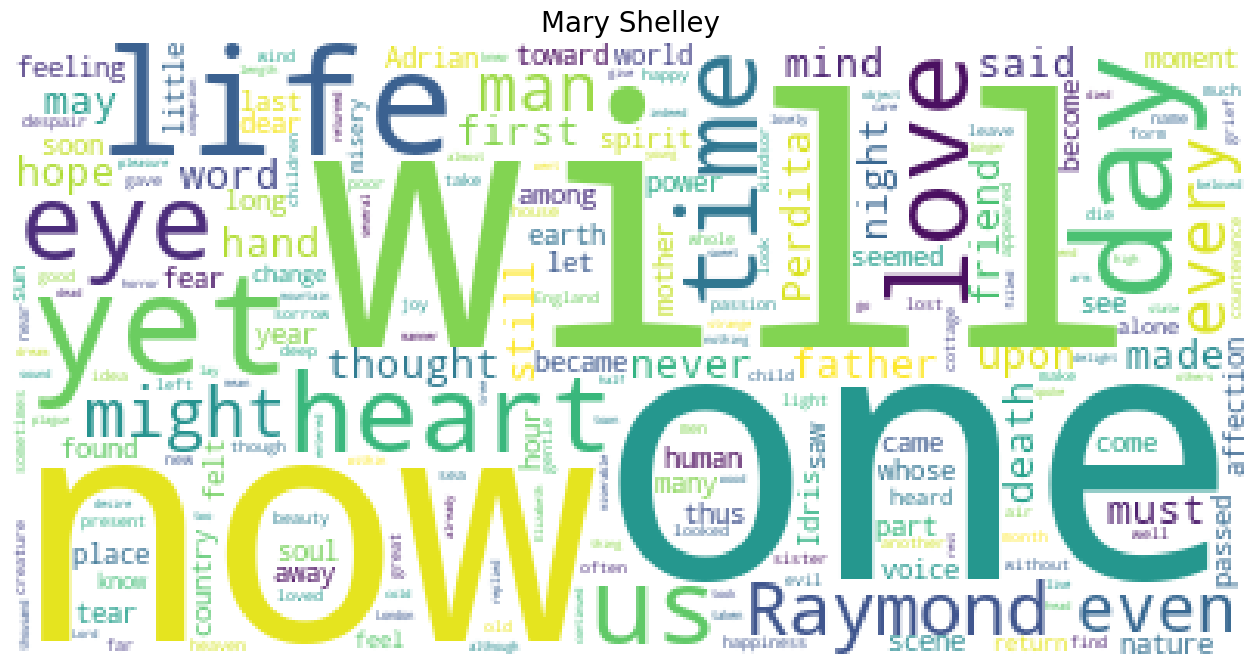

In [25]:
plt.figure(figsize=(16,13))

wordcloud = WordCloud(background_color="white",
                      max_words= 500,
                      contour_width = 8,
                      contour_color = "steelblue",
                     collocations=False).generate(" ".join(mws))

plt.title("Mary Shelley", fontsize=20)
plt.imshow(wordcloud.recolor( colormap= 'viridis' , random_state=17), alpha=0.98)
plt.axis('off')


NLP involves text pre-processing outlined in https://www.educative.io/answers/preprocessing-steps-in-natural-language-processing-nlp:

    Tokenization - Segregation of the text into its individual constitutent words.
    Stopwords - Throw away any words that occur too frequently as its frequency of occurrence will not be useful in helping detecting relevant texts. (as an aside also consider throwing away words that occur very infrequently).
    Stemming - combine variants of words into a single parent word that still conveys the same meaning
    Vectorization - Converting text into vector format. One of the simplest is the famous bag-of-words approach, where you create a matrix (for each document or text in the corpus). In the simplest form, this matrix stores word frequencies (word counts) and is oft referred to as vectorization of the raw text.

After we have our processed text, we want to go down our list of things to further process. So lets perform some tokenization.

Tokenization, in the realm of Natural Language Processing (NLP) and machine learning, refers to the process of converting a sequence of text into smaller parts, known as tokens. These tokens can be as small as characters or as long as words. The primary reason this process matters is that it helps machines understand human language by breaking it down into bite-sized pieces, which are easier to analyze. The primary goal of tokenization is to represent text in a manner that's meaningful for machines without losing its context. By converting text into tokens, algorithms can more easily identify patterns. This pattern recognition is crucial because it makes it possible for machines to understand and respond to human input. (Source: https://www.datacamp.com/blog/what-is-tokenization)

In order to tokenize, we can leverage the nltk library and the method word_tokenize. An example is below.

In [11]:

token_text_example = train.text_processed.values[0]
token_text_example_list = nltk.word_tokenize(token_text_example)
print(token_text_example_list)


['this', 'process', 'however', 'afforded', 'me', 'no', 'means', 'of', 'ascertaining', 'the', 'dimensions', 'of', 'my', 'dungeon', 'as', 'i', 'might', 'make', 'its', 'circuit', 'and', 'return', 'to', 'the', 'point', 'whence', 'i', 'set', 'out', 'without', 'being', 'aware', 'of', 'the', 'fact', 'so', 'perfectly', 'uniform', 'seemed', 'the', 'wall']


Stopward (Source): https://www.oreilly.com/library/view/natural-language-processing/9781787285101/ch02s07.html

In [12]:
#NLTK comes with a predefined list of 179 english stopwords
#Source: https://pythonspot.com/nltk-stop-words/
stopwords = nltk.corpus.stopwords.words('english')
len(stopwords)


179

In [15]:
text_cleaned = []
for word in token_text_example_list:
    if word.lower() not in stopwords:
        text_cleaned.append(word)
print(text_cleaned)
print("Length of original list: {0} words\n"
      "Length of list after stopwords removal: {1} words"
      .format(len(token_text_example_list), len(text_cleaned)))


['process', 'however', 'afforded', 'means', 'ascertaining', 'dimensions', 'dungeon', 'might', 'make', 'circuit', 'return', 'point', 'whence', 'set', 'without', 'aware', 'fact', 'perfectly', 'uniform', 'seemed', 'wall']
Length of original list: 41 words
Length of list after stopwords removal: 21 words


Notice that the size of our list decreases by about half. This is because the commonly occuring words have been removed from our list. After removal of stopwords, the next stage of NLP is the process of Stemming. This attempts to reduce as many different variations of similar words into a single term. For example "Caresses" would become "Caress" or "Ponies" would become "Poni". With this, we must be careful as you can lose granularity.

Source: https://nlp.stanford.edu/IR-book/html/htmledition/stemming-and-lemmatization-1.html


In [26]:
stemmer = nltk.stem.PorterStemmer()


#Example from source above
print("The stemmed form of running is: {}".format(stemmer.stem("caresses")))
print("The stemmed form of runs is: {}".format(stemmer.stem("ponies")))
print("The stemmed form of run is: {}".format(stemmer.stem("cats")))


The stemmed form of running is: caress
The stemmed form of runs is: poni
The stemmed form of run is: cat


However there is one flaw with stemming and that is the fact that the process involves quite a crude heuristic in chopping off the ends of words. This process does not take into account vocabulary or word forms when collapsing words, an example is seen above with ponies.

To account for this, we can look at lemmatization which aims to achieve the same effect as the former method. However unlike a stemmer, lemmatizing the dataset aims to reduce words based on an actual dictionary or vocabulary (the Lemma) and therefore will not chop off words into stemmed forms.

In [27]:
from nltk.stem import WordNetLemmatizer
lemm = WordNetLemmatizer()
print("The lemmatized form of ponies is: {}".format(lemm.lemmatize("ponies")))


The lemmatized form of ponies is: pony


After this, we can look at converting data from the input (text) to real numbers that the ML model will support. This is called vectorization.

Source: https://neptune.ai/blog/vectorization-techniques-in-nlp-guide


In [33]:
example = ["I am showing an example of vectorization",
            "Hopefully this example is helpful"]
vectorizer = CountVectorizer()
sentence_transform = vectorizer.fit_transform(example)

print("The features are:\n {}".format(vectorizer.get_feature_names_out()))
print("\nThe vectorized array looks like:\n {}".format(sentence_transform.toarray()))


The features are:
 ['am' 'an' 'example' 'helpful' 'hopefully' 'is' 'of' 'showing' 'this'
 'vectorization']

The vectorized array looks like:
 [[1 1 1 0 0 0 1 1 0 1]
 [0 0 1 1 1 1 0 0 1 0]]


Now we can put all these together and perform preprocessing on our dataset.

In [35]:
class LemmaCountVectorizer(CountVectorizer):
    def build_analyzer(self):
        analyzer = super(LemmaCountVectorizer, self).build_analyzer()
        return lambda doc: (lemm.lemmatize(word) for word in analyzer(doc))


In [45]:
text = list(train.text.values)
text_processed = list(train.text_processed.values)
tf_vectorizer = LemmaCountVectorizer(max_df=0.95,
                                     min_df=2,
                                     stop_words='english',
                                     decode_error='ignore')
tf_text = tf_vectorizer.fit_transform(text)
tf_text_processed = tf_vectorizer.fit_transform(text_processed)


Text(0.5, 1.0, 'Word Frequency Used')

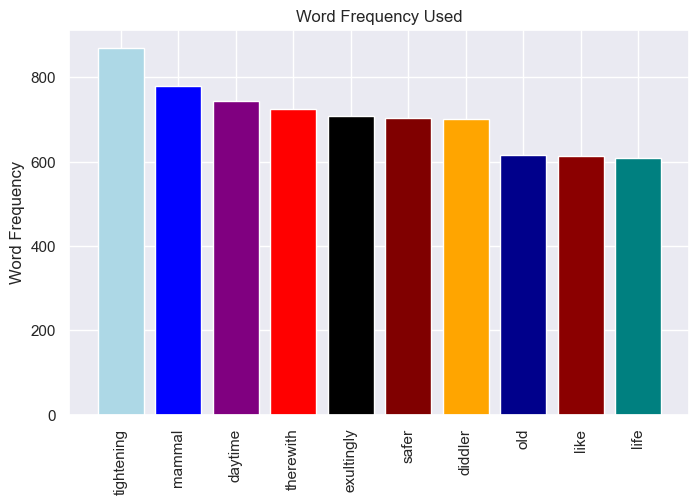

In [97]:
feature_names = tf_vectorizer.get_feature_names_out()
count_vec = np.asarray(tf_text.sum(axis=0)).ravel()
zipped = list(zip(feature_names, count_vec))
x, y = (list(x) for x in zip(*sorted(zipped, key=lambda x: x[1], reverse=True)))


x = x[0:10]
y = y[0:10]
color = ['lightblue', 'blue', 'purple', 'red', 'black', 'maroon', 'orange', 'darkblue', 'darkred', 'teal']
graph = plt.bar(x,y, color=color)
plt.xticks(rotation=90)
plt.ylabel('Word Frequency')
plt.title('Word Frequency Used')


Text(0.5, 1.0, 'Word Frequency Used')

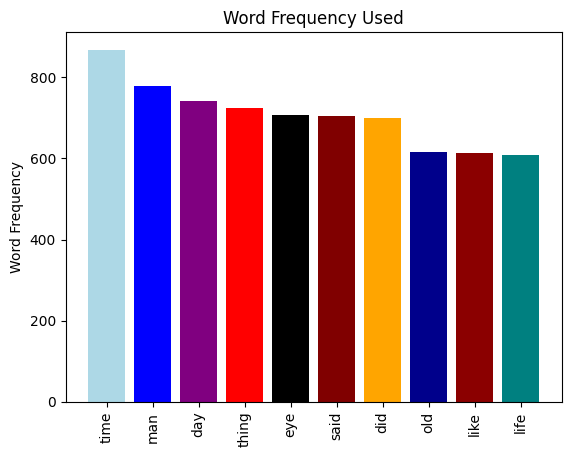

In [48]:
feature_names = tf_vectorizer.get_feature_names_out()
count_vec = np.asarray(tf_text_processed.sum(axis=0)).ravel()
zipped = list(zip(feature_names, count_vec))
x, y = (list(x) for x in zip(*sorted(zipped, key=lambda x: x[1], reverse=True)))


x = x[0:10]
y = y[0:10]
color = ['lightblue', 'blue', 'purple', 'red', 'black', 'maroon', 'orange', 'darkblue', 'darkred', 'teal']
graph = plt.bar(x,y, color=color)
plt.xticks(rotation=90)
plt.ylabel('Word Frequency')
plt.title('Word Frequency Used')


Notice the difference prior to post processing with the word frequency versus after. Additionally looking at the original text versus our processed text.

### Model

### K-Means Approach

In [54]:
train['author_id'] = train['author'].factorize()[0]


In [55]:
train.head(5)


,id,text,author,text_processed,author_id
0,id26305,"This process, however, afforded me no means of...",EAP,this process however afforded me no means of a...,0
1,id17569,It never once occurred to me that the fumbling...,HPL,it never once occurred to me that the fumbling...,1
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP,in his left hand was a gold snuff box from whi...,0
3,id27763,How lovely is spring As we looked from Windsor...,MWS,how lovely is spring as we looked from windsor...,2
4,id12958,"Finding nothing else, not even gold, the Super...",HPL,finding nothing else not even gold the superin...,1


In [56]:
#Resource for Tfidf: https://www.geeksforgeeks.org/understanding-tf-idf-term-frequency-inverse-document-frequency/
train_features = TfidfVectorizer(max_features=10000, ngram_range=(1,2)).fit_transform(train.text_processed).toarray()
test_features = TfidfVectorizer(max_features=10000, ngram_range=(1,2)).fit_transform(test.text).toarray()
print('Train size: ', train_features.shape)
print('Test size: ', test_features.shape)


Train size:  (19579, 10000)
Test size:  (8392, 10000)


In [58]:
#convert train data set to matrix
tfidvec = TfidfVectorizer(sublinear_tf=True,
                          min_df=5,
                          norm='l2',
                          encoding='latin-1',
                          ngram_range=(1, 2),
                          stop_words='english')
features = tfidvec.fit_transform(train.text_processed).toarray()
labels = train.author_id
from sklearn.cluster import KMeans
#k-mean model
km = KMeans(n_clusters = 5,
                init = 'k-means++',
                random_state = 0)
km.fit_transform(tfidvec.fit_transform(train['text_processed']))
k_labels = km.labels_


/usr/local/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



In [59]:
correct_labels = sum(train['author_id'] == k_labels)
train_category_ID = train['author_id']
acc_score = correct_labels/train_category_ID.size
print('Correct labeled: ', correct_labels)
print('Actual size of correct labels: ', train_category_ID.size)
print('Accuracy: ', round(acc_score, 5))


Correct labeled:  5544
Actual size of correct labels:  19579
Accuracy:  0.28316


In [61]:
acc = []
for i in range(1,11):
    kmeans = KMeans(n_clusters = i,
                    init = 'k-means++',
                    random_state = 0)
    kmeans.fit_transform(tfidvec.fit_transform(train['text_processed']))
    k_labels = kmeans.labels_

    correct_labels = sum(train['author_id'] == k_labels)
    catID = train['author_id']
    acc.append(correct_labels/catID.size)

acc = np.array(acc)
maxacc = np.max(acc)
imaxacc = acc.argmax()
print('Best Accuracy score: {0:0.2f} for cluster {1}'. format(maxacc, imaxacc))


/usr/local/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning:

The default value of `n_init` will 

Best Accuracy score: 0.40 for cluster 0


### NMF Approach

In [89]:
from itertools import permutations
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

def dict_gen():
    #Returns a list of dicts that can be used to find the best match with text categories
    list_of_dicts = []
    perms = permutations([0,1,2])
    for perm in perms:
        dict_version = {0: perm[0], 1: perm[1], 2: perm[2]}
        list_of_dicts.append(dict_version)
    return list_of_dicts

def vectorize_data_clean_acc(data):
    #Data cleaning/feature engineering and vectorizing documents
    tfidfvec = TfidfVectorizer(max_df=.95, min_df=3, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')
    features_train = tfidfvec.fit_transform(data['text_processed'])

    nmf_model = NMF(n_components=3, init='random', random_state=123)
    nmf_model.fit(features)

    nmf_model = NMF(n_components=3, init='random', random_state=123)
    nmf_model.fit(features_train)
    for index, topic in enumerate(nmf_model.components_):
        print(f"Top 10 words for {index}")
        print([tfidfvec.get_feature_names_out()[i] for i in topic.argsort()[-10:]])
        print("")

    # We create a list of which category each document belong to and add it to the Dataframe
    topic_results = nmf_model.transform(features_train)
    topic_results = topic_results.argmax(axis=1)
    topic_results = pd.Series(topic_results)

    result = 0
    baseline = 0
    for transformer in dict_gen():
        test = accuracy_score(data['author_id'], topic_results.map(transformer))
        if test > baseline:
            result = test
            t_data = topic_results.map(transformer)
            baseline = test
    print("Accuracy score is: ", result)

    #Confusion Matrix
    cm = confusion_matrix(data['author_id'], t_data) #df_train['nmf_category_id'])
    print(cm)


In [90]:
vectorize_data_clean_acc(train)


Top 10 words for 0
['eyes', 'long', 'like', 'came', 'life', 'night', 'saw', 'old', 'time', 'man']

Top 10 words for 1
['yes', 'dear', 'shall', 'sir', 'know', 'little', 'let', 'said dupin', 'dupin', 'said']

Top 10 words for 2
['did like', 'did appear', 'believe', 'appear', 'night', 'like', 'did know', 'come', 'know', 'did']

Accuracy score is:  0.3933806629552071
[[7201  289  410]
 [5204  293  138]
 [5581  255  208]]


### Supervised Model Compare

In [91]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
#Applying Logistic Regression
model = LogisticRegression(random_state=0)

#Split Data
x_train, x_test, y_train, y_test, indices_train, indices_test = \
train_test_split(features,
                labels,
                train.index,
                test_size=0.33,
                random_state=0)

#Train Algorithm
model.fit(x_train, y_train)

# Make Predictions
y_pred_proba = model.predict_proba(x_test)
y_pred = model.predict(x_test)


/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



In [92]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
#Models we will look at
models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]


In [93]:
CV = 8  # Cross Validate with 8 different folds of 20% data

#Create a data frame that will store the results for all
#5 trials of the 3 different models
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = [] # Initially all entries are empty


In [94]:
from sklearn.model_selection import cross_val_score
#For each Algorithm
for model in models:
    model_name = model.__class__.__name__
    # create 8 models with different 20% test sets, and store their accuracies
    accuracies = cross_val_score(model,
                                 features,
                                 labels,
                                 scoring='accuracy',
                                 cv=CV)
    # Append all 8 accuracies into the entries list
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))

# Store the entries into the results dataframe and name its columns
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])
cv_df


/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/usr/local/lib/python3.11/site-packages/sklearn/

,model_name,fold_idx,accuracy
0,RandomForestClassifier,0,0.404412
1,RandomForestClassifier,1,0.403595
2,RandomForestClassifier,2,0.407680
3,RandomForestClassifier,3,0.404577
4,RandomForestClassifier,4,0.407029
5,RandomForestClassifier,5,0.403351
6,RandomForestClassifier,6,0.404168
7,RandomForestClassifier,7,0.405803
8,MultinomialNB,0,0.820261
9,MultinomialNB,1,0.793709


/usr/local/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/usr/local/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/usr/local/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/usr/local/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/usr/local/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance

<Axes: xlabel='model_name', ylabel='accuracy'>

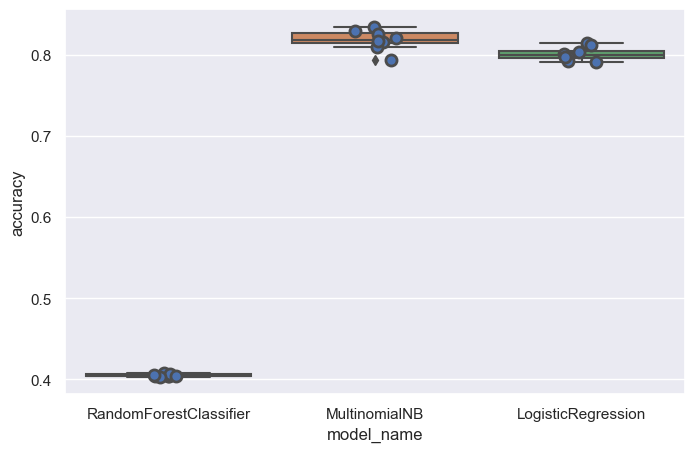

In [96]:
#Visualize the model outputs above
import seaborn as sns
sns.set(rc={"figure.figsize":(8, 5)})
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df,
              size=8, jitter=True, edgecolor="gray", linewidth=2)
